In [1]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing

from twosample import binom_test_two_sided
from multitest import MultiTest

import numpy as np
import scipy


import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm

from scipy.stats import poisson, binom, norm, hypergeom, uniform

import pandas as pd

from sample_survival_data import *

- Min HypGeom 
- Look for data.
    - SCANB ~ 3000 patients ~1000 unique time points
    - Keywords: dose response curve,
    - Perhaps survival of flies
- 

In [2]:
def log_rank_test(Nt1, Nt2):
    """
    log-rank test 
    
    Args:
    -----
    :Nt1:   vector of counts in group 1 (each count corresponds to an event)
    :Nt2:   vector of counts in group 2 
    
    Returns:
    -------
    :z:       z score of the log-rank test
    :pvalue:  P-value
    """
    
    assert(len(Nt1) == len(Nt2))
    T = len(Nt1) - 1

    e0 = np.zeros(T)
    var0 = np.zeros(T)

    Ot1 = -np.diff(Nt1)
    Ot2 = -np.diff(Nt2)
    
    Nt = Nt2 + Nt1
    e0 = Nt1[:-1] * (Ot1 + Ot2) / Nt[:-1]
    var0 = e0 * ( (Nt[:-1] - (Ot1 + Ot2)) /  Nt[:-1]) * (Nt2[:-1] / (Nt[:-1] - 1))
    
    z = np.sum(Ot1 - e0) / np.sqrt(np.sum(var0))
    pval = 2*norm.cdf(-np.abs(z))
    return z, pval

In [3]:
def hypergeom_test(k, M, n, N, alternative = 'greater', randomize=False):
    """
    Exact hypergeometric test
    
    Args:
    -----
    :k:    number of observed Type I objects
    :M:    total number of object
    :n:    total number of Type I objects
    :N:    number of draws
    :randomize:   whether to do a randomized test
    :alternative: type of alternative to consider. Options are: 
                  'greater', 'less', 'two-sided'
    
    """
    
    if randomize:
        U = uniform.rvs(size=len(k))
    else:
        U = 0
        
    if alternative=='greater':
        return hypergeom.sf(k, M, n, N) + U * hypergeom.pmf(k, M, n, N)
    if alternative=='less':
        return hypergeom.cdf(k-1, M, n, N) + U * hypergeom.pmf(k, M, n, N)
    raise ValueError("two-sided alternative is not available yet")

In [4]:
def q95(x):
    """
    Compute the 95-th percentile of the vector x
    """
    if x.dtypes.kind == 'O':
        return np.nan
    else:
        return pd.Series.quantile(x, .95)


In [5]:
def mutli_pvals(Nt1, Nt2):
    """
    Compute P-values from the pair list of coutns in the two group 
    We have one p-value per event time
    An even is a pair (Nt1[i], Nt2[i])
    
    Args:
    -----
    :Nt1:   vector of counts in group 1 (each count corresponds to an event)
    :Nt2:   vector of counts in group 2 
    """
    
    assert(len(Nt1) == len(Nt2))
    
    Ot1 = -np.diff(Nt1)
    Ot2 = -np.diff(Nt2)
    Nt = Nt2 + Nt1
    
    n = Ot1 + Ot2
    p = Nt2[:-1] / Nt[:-1]
    x = Ot2
    
    pvals = hypergeom_test(Ot2, Nt[:-1], Nt2[:-1], Ot1 + Ot2,
                           randomize=True, alternative='greater')
    return pvals


def mutli_pvals_binom(Nt1, Nt2):
    """
    Compute P-values from the pair list of coutns in the two group 
    We have one p-value per event time
    An even is a pair (Nt1[i], Nt2[i])
    
    Args:
    -----
    :Nt1:   vector of counts in group 1 (each count corresponds to an event)
    :Nt2:   vector of counts in group 2 
    """
    
    assert(len(Nt1) == len(Nt2))
    
    Ot1 = -np.diff(Nt1)
    Ot2 = -np.diff(Nt2)
    Nt = Nt2 + Nt1
    
    # binomial p-value; 
    # TODO: replace with a hypergeometric p-value
    # also have a one-sided version
    n = Ot1 + Ot2
    p = Nt2[:-1] / Nt[:-1]
    x = Ot2
    
    pvals = binom_test_two_sided(x, n, p, randomize=True)
    return pvals

In [6]:
def atmoic_experiment(T, N1, N2, eps, mu):
    """
    Sample from survival data; evalaute several test statistics
    
    Args:
    -----
    :T:    time horizon (~ total number of events)
    :N1:   total in group1 at t=0
    :N2:   total in group1 at t=0
    :eps:  fraction of non-null events
    :mu:   intensity of non-null events
    
    """
    
    Nt1, Nt2 = sample_survival_data(T, N1, N2, eps, mu)
    return evaluate_test_stats(Nt1, Nt2)


def evaluate_test_stats(Nt1, Nt2):
    """
    Args:
    :Nt1: first list of events
    :Nt2: second list of events
    
    Compute several statistics of the two-sample data:
    log-rank
    higher criticism
    Fisher combination test
    minimum P-value
    Berk-Jones
    Wilcoxon ranksum
    """
    
    lr, lr_pval = log_rank_test(Nt1, Nt2)
    pvals = mutli_pvals(Nt1, Nt2)
    mt = MultiTest(pvals, stbl=False) # if not using stbl=False, then sometimes
                                      # HC misses the significance of the strongest effect 
    
    return {'Logrank': np.abs(lr),
            'HC': mt.hc()[0],
            'Fisher': mt.fisher()[0],
            'minP': mt.minp(),
            'BJ': mt.berk_jones(gamma=.45),
            'wilcoxon': -np.log(1e-20 + scipy.stats.ranksums(Nt1, Nt2).pvalue),
           }

## Load Data:

In [12]:
#df = pd.read_csv("./Data/Gene_expression_data/AML_Bull.csv")
df = pd.read_csv("./Data/data.csv")
gene_names = [c for c in df.columns if c not in ['Unnamed: 0', 'time', 'event']]


In [8]:
gene_name = np.random.choice(gene_names, 1, replace=False)[0]
gene_name = gene_names[0]

In [9]:
def arrange_group(dfg):
    """
    Group events in time; Find group size in each 
    time sample
    """
    
    dft = dfg.groupby('time').sum()
    dft = dft.sort_values('time')
    dft['total'] = len(dft)
    dft['dead'] = dft.event.cumsum()
    dft['survived'] = dft['total'] - dft['dead']
    return dft

def two_groups_gene(data, gene_name):
    """
    Arranges relevant data in a two groups format
    for survival analysis based on the examined gene
    
    Args:
    :data:   is a dataframe with :gene_name: as one of its columns.
             additional columns are :time: and :event:
             
    Return:
        dataframe indexed by time and number of survived elements in
        each group
    
    """
    
    dfg = data[[gene_name,'time', 'event']]
    idc_split = dfg[gene_name] >= 1    
    df1 = arrange_group(dfg[idc_split])
    df2 = arrange_group(dfg[~idc_split])
    
    return df1[['survived']].join(df2[['survived']], lsuffix='1', rsuffix='2', how='outer')\
                     .fillna(method='ffill')\
                     .fillna(method='bfill')

In [33]:
res = pd.DataFrame()
for gene_name in tqdm(gene_names):
    try:
        dfr = two_groups_gene(df, gene_name)
        r = evaluate_test_stats(dfr['survived1'].values, dfr['survived2'].values)
        rrev = evaluate_test_stats(dfr['survived2'].values, dfr['survived1'].values)
        
        r['name'] = gene_name
        rrev['name'] = gene_name + '_rev'
        
        res = res.append(r, ignore_index=True)
        res = res.append(rrev, ignore_index=True)
    except:
        print(f"Error in evaluating {gene_name}")


100%|██████████| 9259/9259 [02:41<00:00, 57.36it/s]


             BJ   |  Fisher     |  HC      | Logrank  |  minP     | wilcoxon |
null_95q | 6.911782 | 4071.702032 | 4.777988 | 1.960859 | 10.620356 | 14.365465|


In [23]:
resi = res[(res.HC > 6) & (res.Logrank < 1) & (res.wilcoxon < 14)]

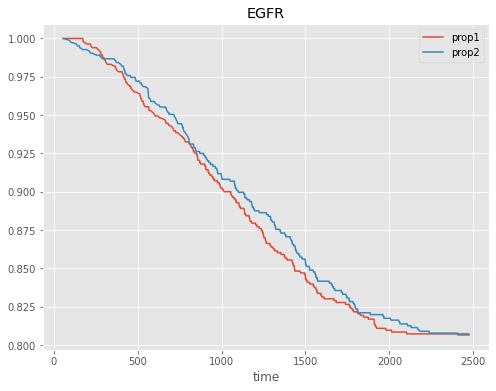

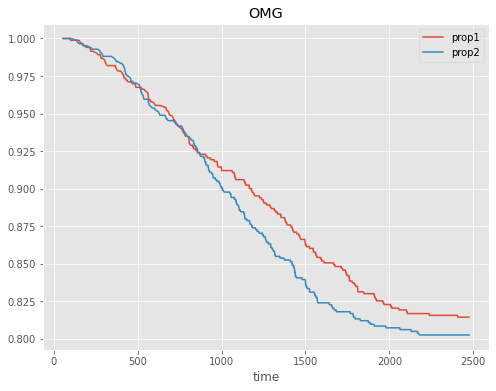

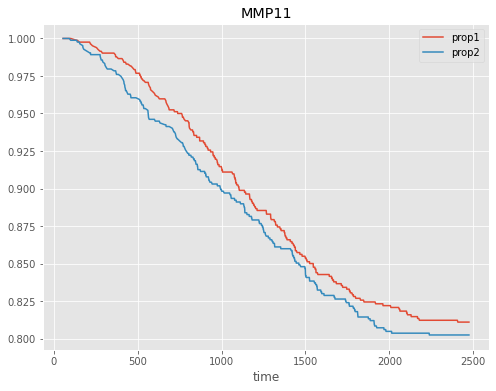

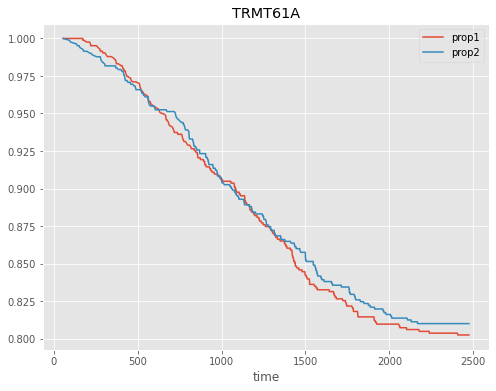

In [25]:
for gene_name in resi.name.sample(n=4):
    dfg = two_groups_gene(df, gene_name) 
    dfg['prop1'] = dfg['survived1'] / dfg['survived1'].max()
    dfg['prop2'] = dfg['survived2'] / dfg['survived2'].max()
    dfg.plot(y=['prop1', 'prop2'])
    plt.title(f"{gene_name}")
    plt.show()

## Atomic experiment:

In [12]:
Nt1, Nt2 = sample_survival_data(T, N1, N2, eps, mu)
evaluate_test_stats(Nt1, Nt2)

{'Logrank': 5.952263207723344,
 'HC': 134.11062194288294,
 'Fisher': 4234.682178177006,
 'minP': 17.089574035423794,
 'BJ': 14.508657620446826,
 'wilcoxon': 101.14994959179218}

In [55]:
df.event.mean()

0.10492016943629846

In [56]:
len(df)

3069

In [59]:
df.time.min()

56.0